In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap

In [ ]:
df = pd.read_csv('london_merged.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df_model = df.drop(columns=['timestamp'])

In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_model), columns=df_model.columns)

In [ ]:
input_dim = df_scaled.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim,))
encoded = Dense(12, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(12, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(df_scaled, df_scaled,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=0)

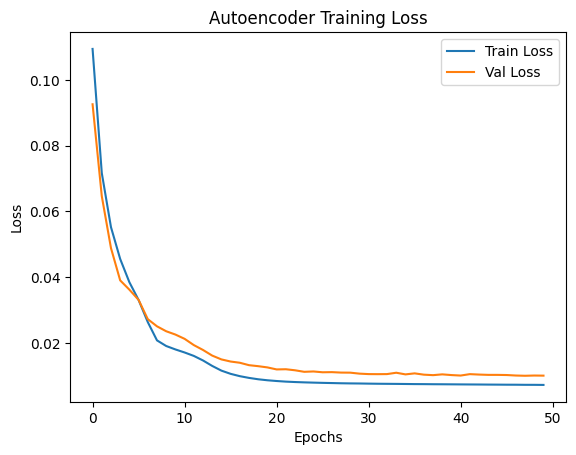

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
encoded_features = encoder.predict(df_scaled)

545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_features)

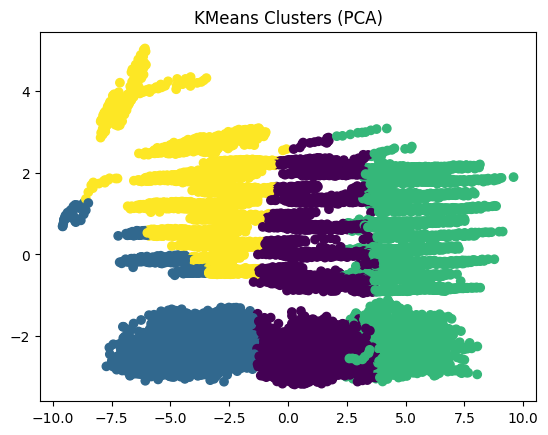

In [ ]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(encoded_features)

plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans Clusters (PCA)")
plt.show()

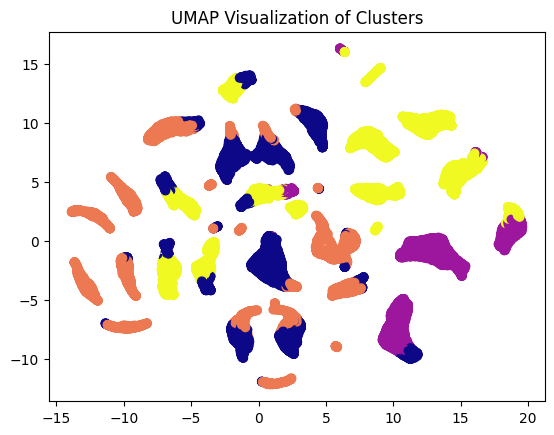

In [ ]:
reducer = umap.UMAP(random_state=42)
umap_reduced = reducer.fit_transform(encoded_features)

plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], c=kmeans_labels, cmap='plasma')
plt.title("UMAP Visualization of Clusters")
plt.show()

In [ ]:
print("Silhouette Score:", silhouette_score(encoded_features, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(encoded_features, kmeans_labels))
print("Calinski-Harabasz Score:", calinski_harabasz_score(encoded_features, kmeans_labels))

Silhouette Score: 0.28880787
Davies-Bouldin Index: 1.2818414632917872
Calinski-Harabasz Score: 14458.112


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=20)
db_labels = dbscan.fit_predict(encoded_features)

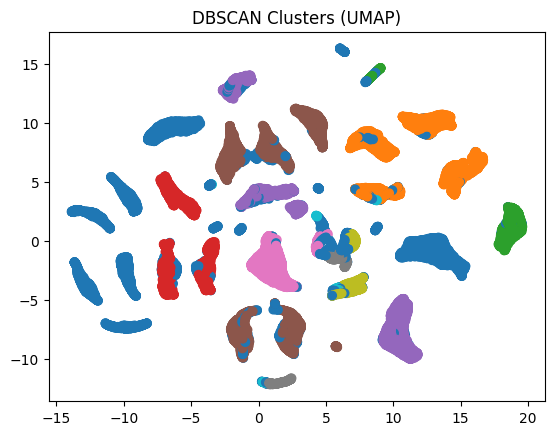

In [ ]:
plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], c=db_labels, cmap='tab10')
plt.title("DBSCAN Clusters (UMAP)")
plt.show()

In [ ]:
print("KMeans Cluster Sizes:", np.bincount(kmeans_labels))
print("DBSCAN Cluster Sizes:", np.bincount(db_labels[db_labels >= 0]))

KMeans Cluster Sizes: [4784 2940 4711 4979]
DBSCAN Cluster Sizes: [ 788 1899 1237  416  632 1204  568   34   41  579  577  601  602  571
 1232 1773  597  594 1199   20  116  135   46  147  107  246   69   27
   31   20   16]


In [ ]:
# Apply inverse transform to the original scaled data and group by cluster
cluster_centers_original_scale = scaler.inverse_transform(df_scaled)
cluster_centers = pd.DataFrame(cluster_centers_original_scale, columns=df_model.columns)
cluster_centers['cluster'] = kmeans_labels
cluster_centers = cluster_centers.groupby('cluster').mean()

cluster_centers

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,dayofweek,month
cluster,,,,,,,,,,,,
0,1154.545151,13.960040,13.527766,74.979515,15.161127,2.818771,0.022366,0.314799,1.903637,11.187291,3.173704,9.133988
1,1140.541156,13.855272,13.143367,68.470833,15.608078,2.537075,0.011905,0.791497,0.404082,9.860544,5.179252,5.258844
2,910.414137,8.066865,6.205370,77.667480,16.464020,3.011675,0.007217,0.241350,2.831458,13.569943,2.746763,5.825302
3,1353.781081,14.379795,13.663788,66.995180,16.294336,2.466760,0.041775,0.000000,0.471781,10.856397,1.760193,5.391645


In [ ]:
df['cluster'] = kmeans_labels
df.groupby('cluster')['cnt'].mean()

,cnt
cluster,
0,1154.545151
1,1140.541156
2,910.414137
3,1353.781081


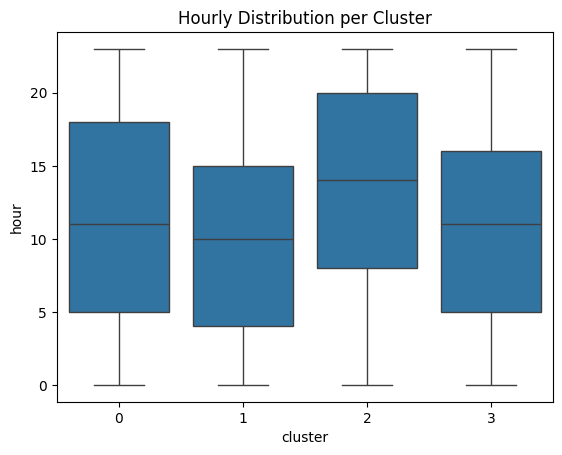

In [ ]:
sns.boxplot(data=df, x='cluster', y='hour')
plt.title("Hourly Distribution per Cluster")
plt.show()

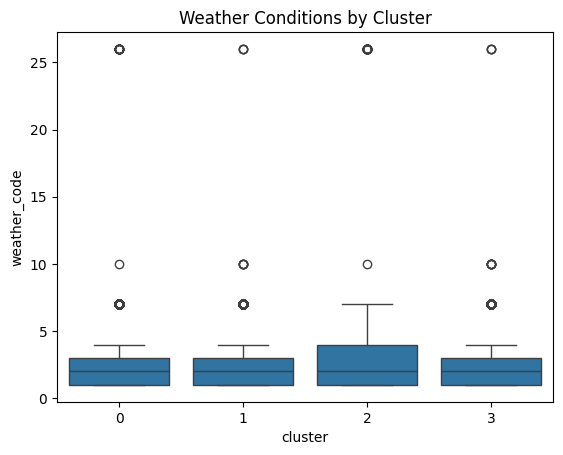

In [ ]:
sns.boxplot(data=df, x='cluster', y='weather_code')
plt.title("Weather Conditions by Cluster")
plt.show()

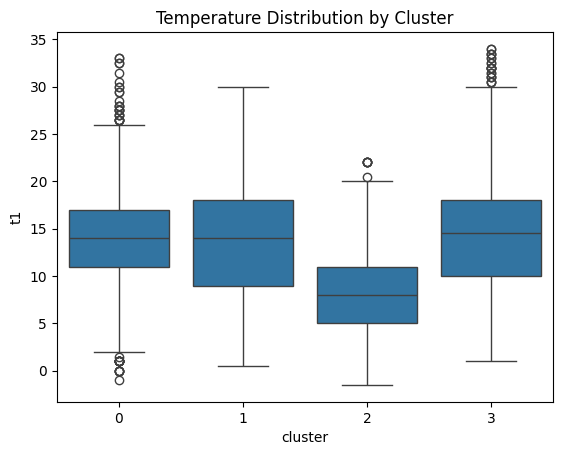

In [ ]:
sns.boxplot(data=df, x='cluster', y='t1')
plt.title("Temperature Distribution by Cluster")
plt.show()

In [ ]:
encoded_df = pd.DataFrame(encoded_features, columns=[f'feat_{i}' for i in range(encoding_dim)])
encoded_df['cluster'] = kmeans_labels
encoded_df.to_csv("encoded_clusters.csv", index=False)